<a href="https://colab.research.google.com/github/medsellufbc/BMI/blob/main/LogisticSL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[Text(0, 0.5, 'Cases'), Text(0.5, 0, 'Days since...')]

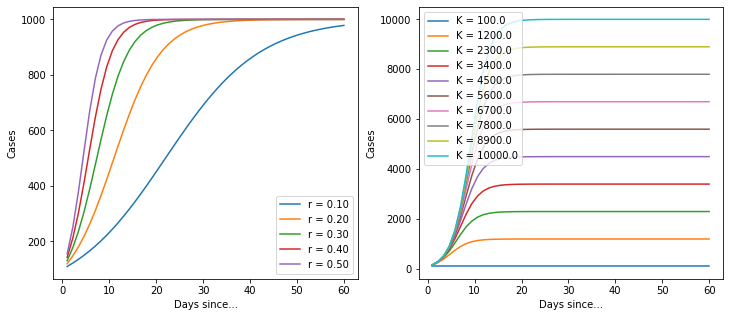

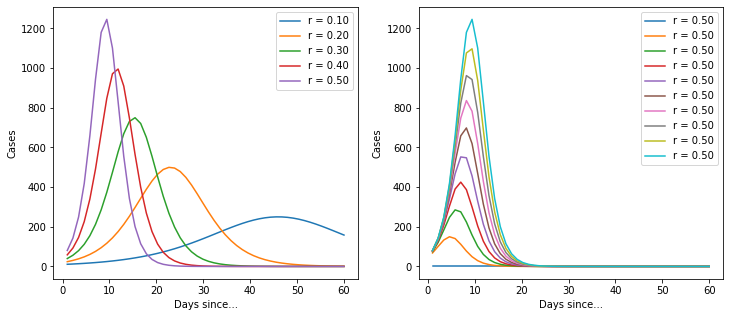

In [1]:
import numpy as np
import matplotlib.pyplot as plt

def C(K, r, t, C_0):
  A = (K-C_0)/C_0
  return K / (1 + A * np.exp(-r * t))

def d_C(K, r, t, C_0):
  c = C(K, r, t, C_0)
  return r * c * (1 - c / K)

r = 0.2
K = 1000
C_0 = 100

t = np.linspace(1,60)

fig, ax = plt.subplots(1, 2, figsize=(12,5))
for r in np.linspace(0.1, 0.5, 5):
  ax[0].plot(t, C(K, r, t, C_0), label=f"r = {r:0.2f}")
ax[0].legend(loc="best")
ax[0].set(xlabel="Days since...", ylabel="Cases")
for K in np.linspace(100, 10000, 10):
  ax[1].plot(t, C(K, r, t, C_0), label=f"K = {K:0.1f}")
ax[1].legend(loc="best")
ax[1].set(xlabel="Days since...", ylabel="Cases")

fig, ax = plt.subplots(1, 2, figsize=(12,5))
for r in np.linspace(0.1, 0.5, 5):
  ax[0].plot(t, d_C(K, r, t, C_0), label=f"r = {r:0.2f}")
ax[0].legend(loc="best")
ax[0].set(xlabel="Days since...", ylabel="Cases")
for K in np.linspace(100, 10000, 10):
  ax[1].plot(t, d_C(K, r, t, C_0), label=f"r = {r:0.2f}")
ax[1].legend(loc="best")
ax[1].set(xlabel="Days since...", ylabel="Cases")

In [2]:
!pip install pymc3


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
!pip install arviz==0.11.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
import numpy as np
import pymc3 as pm
import pandas as pd
import matplotlib.pyplot as plt
import theano

In [5]:
# Load data
df = pd.read_csv("https://opendata.ecdc.europa.eu/covid19/casedistribution/csv/", parse_dates=["dateRep"], infer_datetime_format=True, dayfirst=True)
df = df.rename(columns={'dateRep': 'date', 'countriesAndTerritories': 'country'}) # Sane column names
df = df.drop(["day", "month", "year", "geoId"], axis=1) # Not required


In [12]:
country = "Sierra_Leone"
# Filter for country (probably want separate models per country, even maybe per region)
sorted_country = df[df["country"] == country].sort_values(by="date")
# Cumulative sum of data
country_cumsum = sorted_country[["cases", "deaths"]].cumsum().set_index(sorted_country["date"])
# Filter out data with less than 100 cases
country_cumsum = country_cumsum[country_cumsum["cases"] >= 100]
days_since_100 = range(len(country_cumsum))

In [13]:
# Pull out population size per country
populations = {key: df[df["country"] == key].iloc[0]["popData2019"] for key in df["country"].unique()}

In [14]:
def model_factory(country: str, x: np.ndarray, y: np.ndarray):
  with pm.Model() as model:
    t = pm.Data(country + "x_data", x)
    confirmed_cases = pm.Data(country + "y_data", y)

    # Intercept - We fixed this at 100.
    C_0 = pm.Normal("C_0", mu=100, sigma=10)

    # Growth rate: 0.2 is approx value reported by others
    r = pm.Normal("r", mu=0.2, sigma=0.5)

    # Total number of cases. Depends on the population, more people, more infections.
    # It also depends on the total number of people infected.
    # Start with a prior based upon a guess of the initial population, very weak
    proportion_infected = 5e-05 # This value comes from the rough projection that 80000 will be infected in China
    p = populations[country]
    K = pm.Normal("K", mu=p * proportion_infected, sigma=p*0.1)

    # Logistic regression
    growth = C(K, r, t, C_0)

    # Likelihood error
    eps = pm.HalfNormal("eps")

    # Likelihood - Counts here, so poission or negative binomial. Causes issues. Lognormal tends to work better?
    pm.Lognormal(country, mu=np.log(growth), sigma=eps, observed=confirmed_cases)
  return model

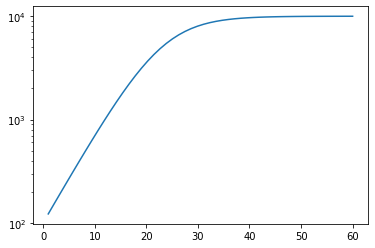

In [19]:
r = 0.2
K = 10000 # This should look something a bit like China
C_0 = 100
t = np.linspace(1,60)
y_synthetic = C(K, r, t, C_0)
plt.plot(t, y_synthetic)
plt.gca().set_yscale("log")

Sampling chain 1, 62 divergences: 100%|██████████| 1000/1000 [00:08<00:00, 119.28it/s]
ERROR:pymc3:There were 137 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 199 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
ERROR:pymc3:The estimated number of effective samples is smaller than 200 for some parameters.
/usr/local/lib/python3.8/dist-packages/arviz/stats/density_utils.py:770: UserWarning: Something failed when estimating the bandwidth. Please check your data
  warnings.warn("Something failed when estimating the bandwidth. Please check your data")
/usr/local/lib/python3.8/dist-packages/arviz/stats/density_utils.py:770: UserWarning: Something failed when estimating the bandwidth. Please check your data
  warnings.warn("Something failed when estimating the bandwidth. Please check your data")
/usr/local/lib/python3.8/dist

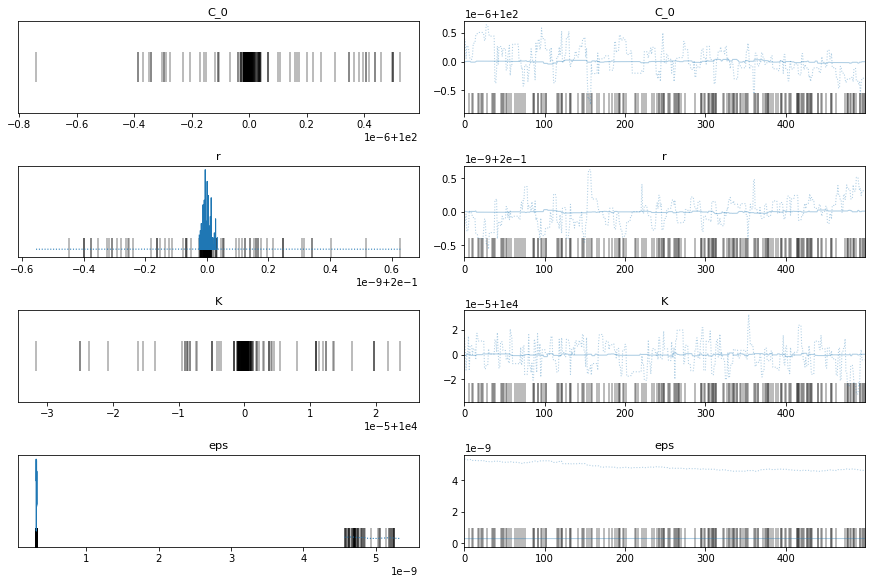

/usr/local/lib/python3.8/dist-packages/IPython/core/pylabtools.py:128: UserWarning: constrained_layout not applied.  At least one axes collapsed to zero width or height.
  fig.canvas.print_figure(bytes_io, **kw)


ValueError: ignored

<Figure size 1987.2x331.2 with 4 Axes>

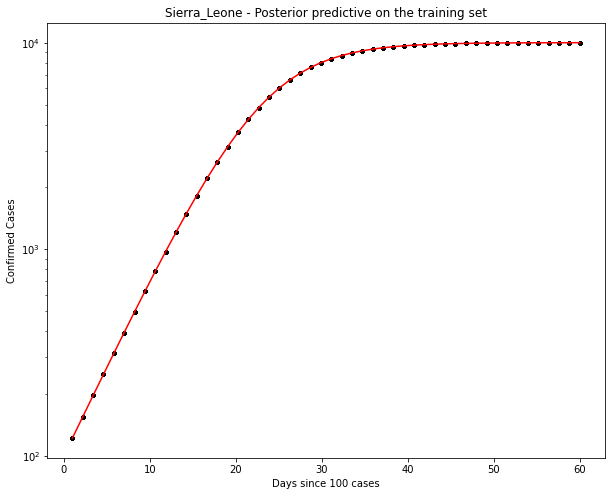

In [20]:
# Training
with model_factory(country, t, y_synthetic) as model:
    train_trace = pm.sample()
    pm.traceplot(train_trace)
    pm.plot_posterior(train_trace)
    ppc = pm.sample_posterior_predictive(train_trace)
    fig, ax = plt.subplots(figsize=(10, 8))
    ax.plot(t, ppc[country].T, ".k", alpha=0.05)
    ax.plot(t, y_synthetic, color="r")
    ax.set_yscale("log")
    ax.set(xlabel="Days since 100 cases", ylabel="Confirmed Cases", title=f"{country} - Posterior predictive on the training set")

100%|██████████| 1000/1000 [00:10<00:00, 91.81it/s]


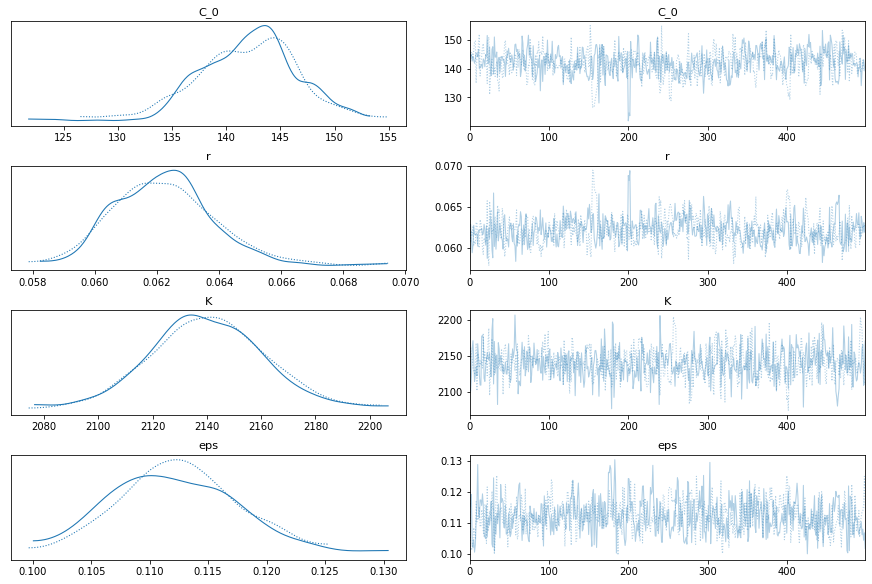

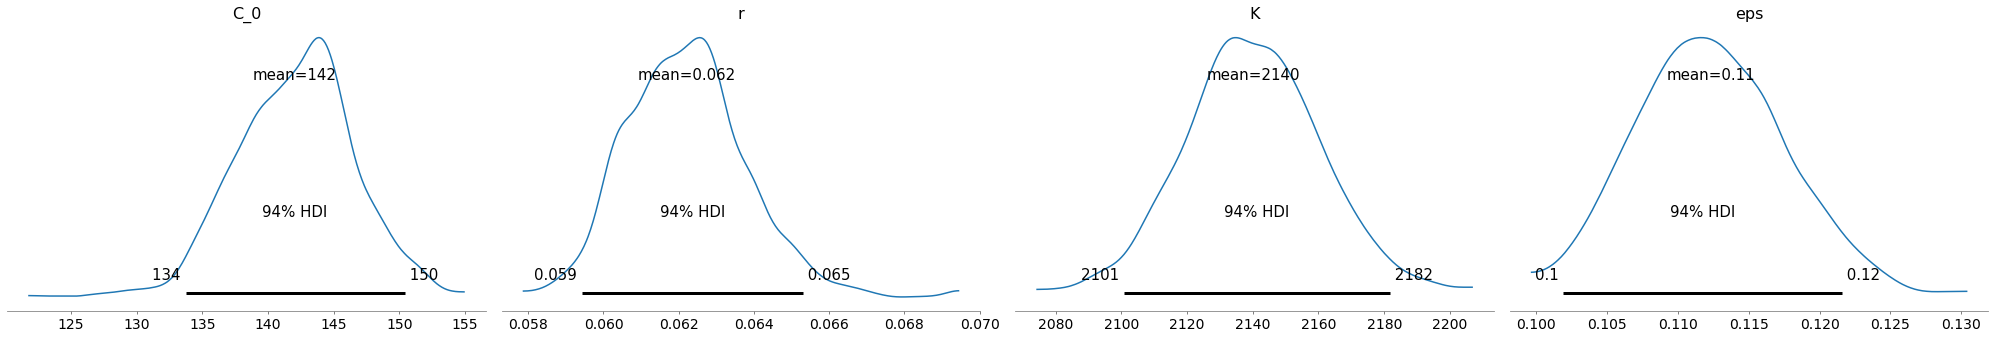

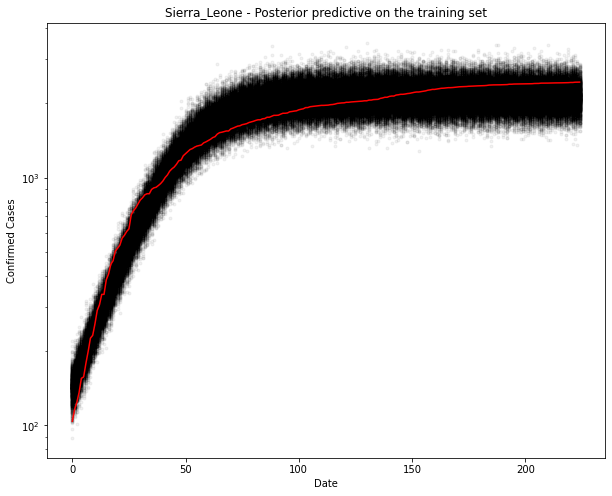

In [21]:
train_x = days_since_100[:-5]
train_y = country_cumsum["cases"].astype('float64').values[:-5]
hold_out_x = days_since_100[-5:]
hold_out_y = country_cumsum["cases"].astype('float64').values[-5:]
# Training
with model_factory(country, train_x, train_y) as model:
    train_trace = pm.sample()
    pm.traceplot(train_trace)
    pm.plot_posterior(train_trace)
    ppc = pm.sample_posterior_predictive(train_trace)
    fig, ax = plt.subplots(figsize=(10, 8))
    ax.plot(train_x, ppc[country].T, ".k", alpha=0.05)
    ax.plot(train_x, train_y, color="r")
    ax.set_yscale("log")
    ax.set(xlabel="Date", ylabel="Confirmed Cases", title=f"{country} - Posterior predictive on the training set")

100%|██████████| 1000/1000 [00:11<00:00, 90.56it/s]


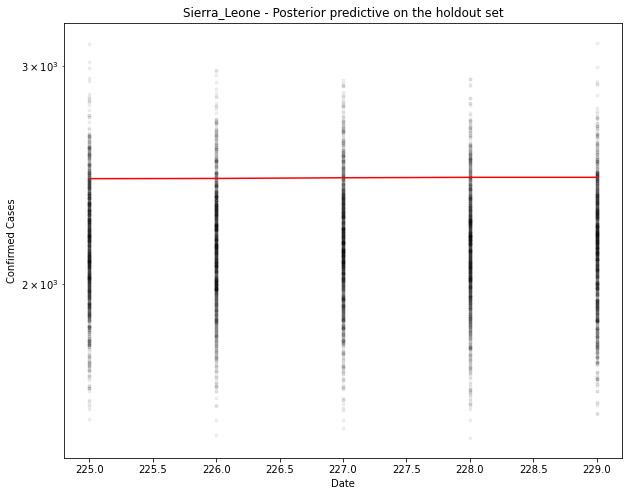

In [22]:
with model_factory(country, hold_out_x, hold_out_y) as test_model:
    ppc = pm.sample_posterior_predictive(train_trace)
    fig, ax = plt.subplots(figsize=(10, 8))
    ax.plot(hold_out_x, ppc[country].T, ".k", alpha=0.05)
    ax.plot(hold_out_x, hold_out_y, color="r")
    ax.set_yscale("log")
    ax.set(xlabel="Date", ylabel="Confirmed Cases", title=f"{country} - Posterior predictive on the holdout set")

In [23]:
# Generate the predicted number of cases (assuming normally distributed on the output)
predicted_cases = ppc[country].mean(axis=0).round()
print(predicted_cases)
def error(actual, predicted):
  return predicted - actual

def print_errors(actuals, predictions):
  for n in [1, 5]:
    act, pred = actuals[n-1], predictions[n-1]
    err = error(act, pred)
    print(f"{n}-day cumulative prediction error: {err} cases ({100 * err / act:.1f} %)")

print_errors(hold_out_y, predicted_cases)

[2160. 2154. 2166. 2144. 2151.]
1-day cumulative prediction error: -274.0 cases (-11.3 %)
5-day cumulative prediction error: -289.0 cases (-11.8 %)


In [26]:
new_x = [hold_out_x[-1] + 1, hold_out_x[-1] + 5]
new_y = [0, 0]
# Predictive model
with model_factory(country, new_x, new_y) as test_model:
    ppc = pm.sample_posterior_predictive(train_trace)
predicted_cases = ppc[country].mean(axis=0).round()
print("\n")
print(f"Based upon this model, tomorrow's number of cases will be {predicted_cases[0]}. In 5 days time there will be {predicted_cases[1]} cases.")

100%|██████████| 1000/1000 [00:11<00:00, 86.71it/s]



Based upon this model, tomorrow's number of cases will be 2161.0. In 5 days time there will be 2143.0 cases.


100%|██████████| 1000/1000 [00:11<00:00, 87.75it/s]


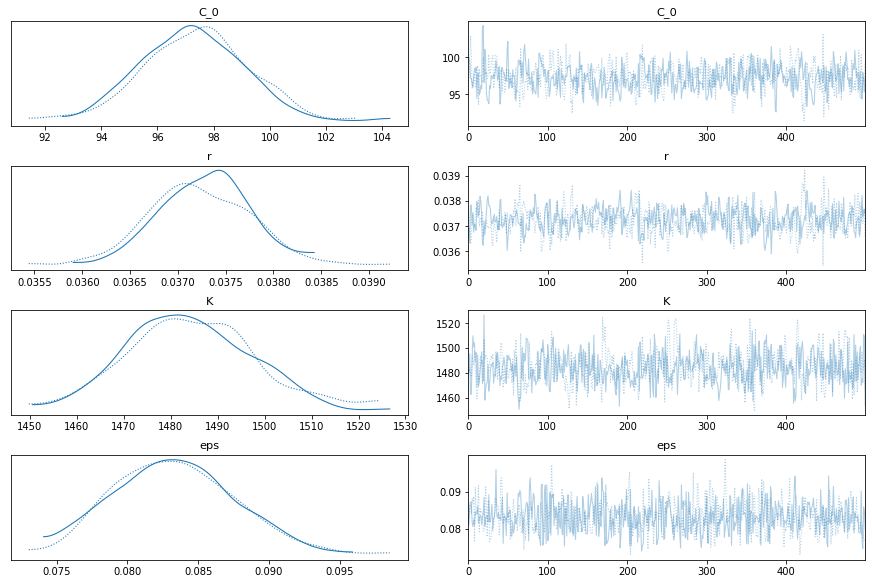

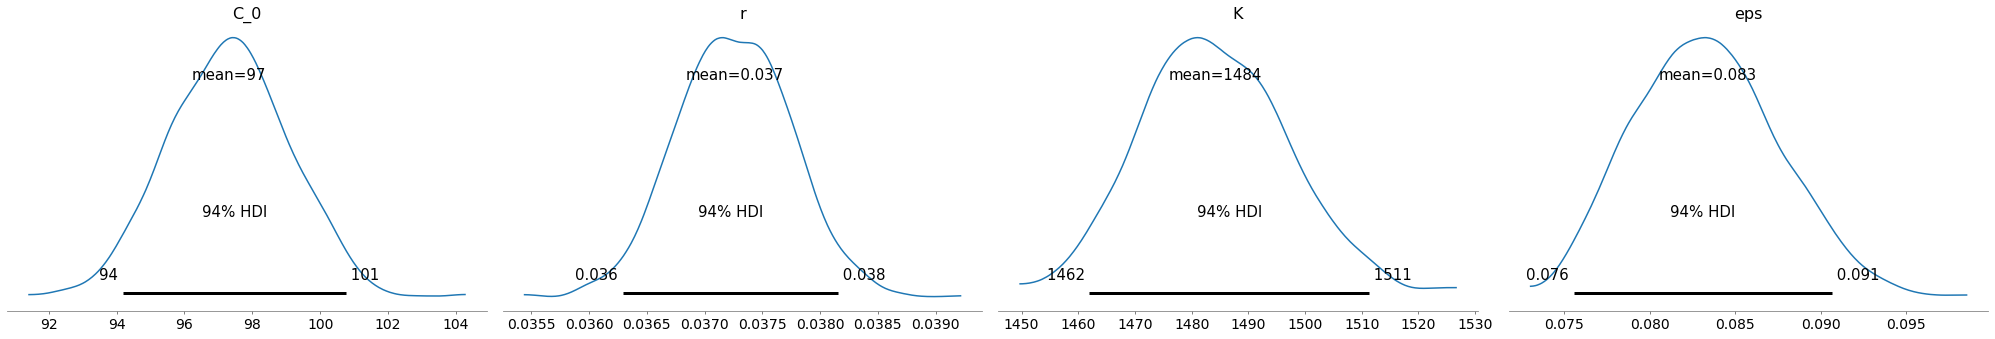

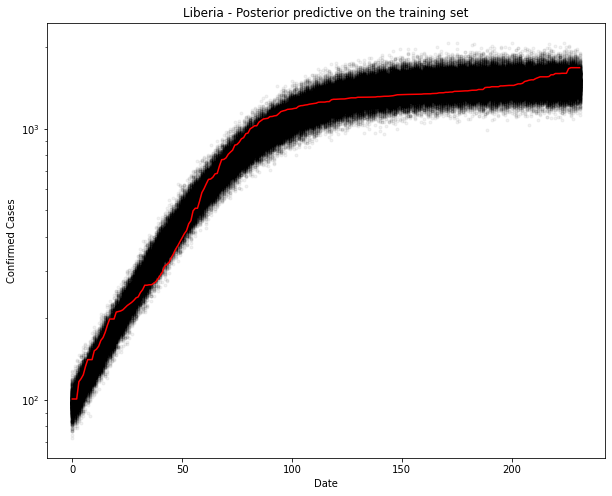

In [27]:
country = "Liberia"
# Filter for country (probably want separate models per country, even maybe per region)
sorted_country = df[df["country"] == country].sort_values(by="date")
# Cumulative sum of data
country_cumsum = sorted_country[["cases", "deaths"]].cumsum().set_index(sorted_country["date"])
# Filter out data with less than 100 cases
country_cumsum = country_cumsum[country_cumsum["cases"] >= 100]
days_since_100 = range(len(country_cumsum))

# Pull out population size per country
populations = {key: df[df["country"] == key].iloc[0]["popData2019"] for key in df["country"].unique()}
train_x = days_since_100[:-5]
train_y = country_cumsum["cases"].astype('float64').values[:-5]
hold_out_x = days_since_100[-5:]
hold_out_y = country_cumsum["cases"].astype('float64').values[-5:]
# Training
with model_factory(country, train_x, train_y) as model:
    train_trace = pm.sample()
    pm.traceplot(train_trace)
    pm.plot_posterior(train_trace)
    ppc = pm.sample_posterior_predictive(train_trace)
    fig, ax = plt.subplots(figsize=(10, 8))
    ax.plot(train_x, ppc[country].T, ".k", alpha=0.05)
    ax.plot(train_x, train_y, color="r")
    ax.set_yscale("log")
    ax.set(xlabel="Date", ylabel="Confirmed Cases", title=f"{country} - Posterior predictive on the training set")

100%|██████████| 1000/1000 [00:11<00:00, 90.50it/s]


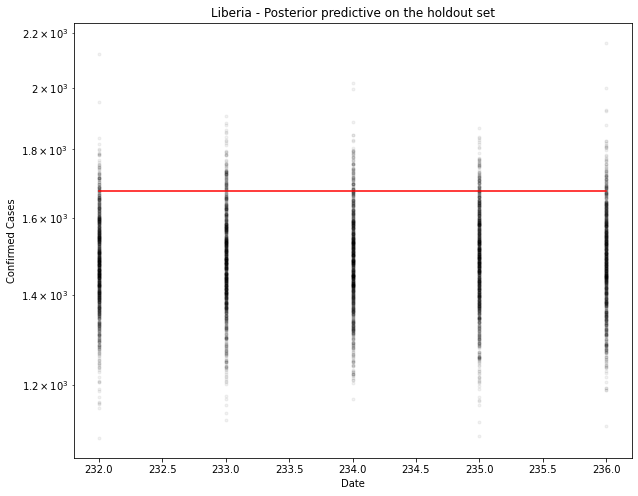

In [28]:
with model_factory(country, hold_out_x, hold_out_y) as test_model:
    ppc = pm.sample_posterior_predictive(train_trace)
    fig, ax = plt.subplots(figsize=(10, 8))
    ax.plot(hold_out_x, ppc[country].T, ".k", alpha=0.05)
    ax.plot(hold_out_x, hold_out_y, color="r")
    ax.set_yscale("log")
    ax.set(xlabel="Date", ylabel="Confirmed Cases", title=f"{country} - Posterior predictive on the holdout set")

In [29]:
# Generate the predicted number of cases (assuming normally distributed on the output)
predicted_cases = ppc[country].mean(axis=0).round()
print(predicted_cases)
def error(actual, predicted):
  return predicted - actual

def print_errors(actuals, predictions):
  for n in [1, 5]:
    act, pred = actuals[n-1], predictions[n-1]
    err = error(act, pred)
    print(f"{n}-day cumulative prediction error: {err} cases ({100 * err / act:.1f} %)")

print_errors(hold_out_y, predicted_cases)

[1485. 1489. 1491. 1489. 1493.]
1-day cumulative prediction error: -191.0 cases (-11.4 %)
5-day cumulative prediction error: -183.0 cases (-10.9 %)


In [30]:
new_x = [hold_out_x[-1] + 1, hold_out_x[-1] + 5]
new_y = [0, 0]
# Predictive model
with model_factory(country, new_x, new_y) as test_model:
    ppc = pm.sample_posterior_predictive(train_trace)
predicted_cases = ppc[country].mean(axis=0).round()
print("\n")
print(f"Based upon this model, tomorrow's number of cases will be {predicted_cases[0]}. In 5 days time there will be {predicted_cases[1]} cases.")

100%|██████████| 1000/1000 [00:11<00:00, 83.39it/s]



Based upon this model, tomorrow's number of cases will be 1490.0. In 5 days time there will be 1484.0 cases.


100%|██████████| 1000/1000 [00:11<00:00, 85.59it/s]


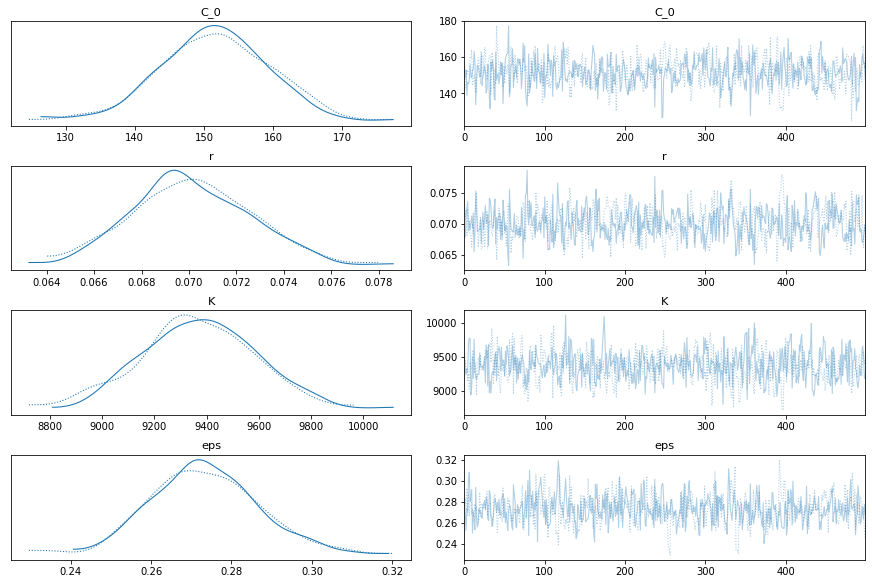

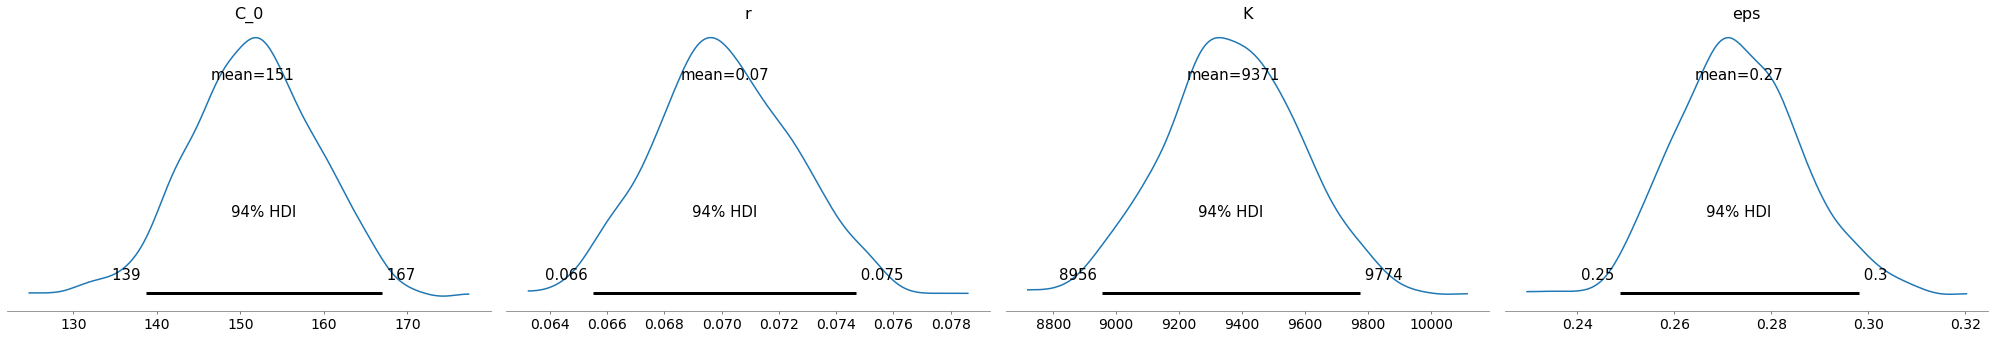

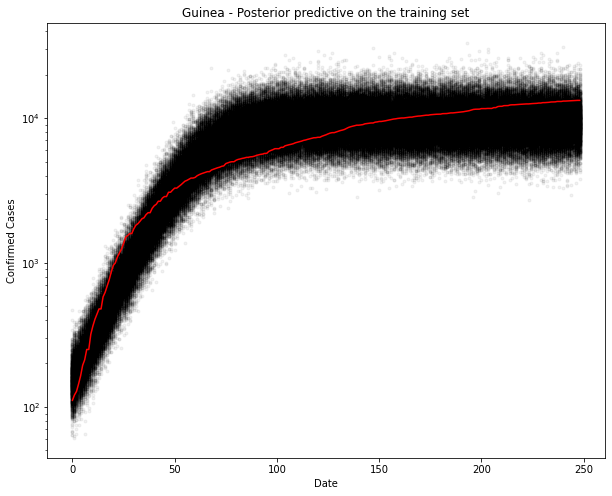

In [31]:
country = "Guinea"
# Filter for country (probably want separate models per country, even maybe per region)
sorted_country = df[df["country"] == country].sort_values(by="date")
# Cumulative sum of data
country_cumsum = sorted_country[["cases", "deaths"]].cumsum().set_index(sorted_country["date"])
# Filter out data with less than 100 cases
country_cumsum = country_cumsum[country_cumsum["cases"] >= 100]
days_since_100 = range(len(country_cumsum))

# Pull out population size per country
populations = {key: df[df["country"] == key].iloc[0]["popData2019"] for key in df["country"].unique()}
train_x = days_since_100[:-5]
train_y = country_cumsum["cases"].astype('float64').values[:-5]
hold_out_x = days_since_100[-5:]
hold_out_y = country_cumsum["cases"].astype('float64').values[-5:]
# Training
with model_factory(country, train_x, train_y) as model:
    train_trace = pm.sample()
    pm.traceplot(train_trace)
    pm.plot_posterior(train_trace)
    ppc = pm.sample_posterior_predictive(train_trace)
    fig, ax = plt.subplots(figsize=(10, 8))
    ax.plot(train_x, ppc[country].T, ".k", alpha=0.05)
    ax.plot(train_x, train_y, color="r")
    ax.set_yscale("log")
    ax.set(xlabel="Date", ylabel="Confirmed Cases", title=f"{country} - Posterior predictive on the training set")

100%|██████████| 1000/1000 [00:13<00:00, 74.17it/s]


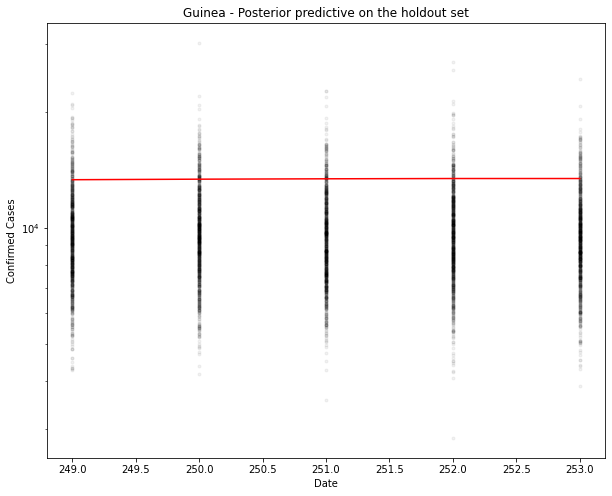

In [32]:
with model_factory(country, hold_out_x, hold_out_y) as test_model:
    ppc = pm.sample_posterior_predictive(train_trace)
    fig, ax = plt.subplots(figsize=(10, 8))
    ax.plot(hold_out_x, ppc[country].T, ".k", alpha=0.05)
    ax.plot(hold_out_x, hold_out_y, color="r")
    ax.set_yscale("log")
    ax.set(xlabel="Date", ylabel="Confirmed Cases", title=f"{country} - Posterior predictive on the holdout set")

In [33]:
# Generate the predicted number of cases (assuming normally distributed on the output)
predicted_cases = ppc[country].mean(axis=0).round()
print(predicted_cases)
def error(actual, predicted):
  return predicted - actual

def print_errors(actuals, predictions):
  for n in [1, 5]:
    act, pred = actuals[n-1], predictions[n-1]
    err = error(act, pred)
    print(f"{n}-day cumulative prediction error: {err} cases ({100 * err / act:.1f} %)")

print_errors(hold_out_y, predicted_cases)

[9745. 9901. 9623. 9779. 9635.]
1-day cumulative prediction error: -3580.0 cases (-26.9 %)
5-day cumulative prediction error: -3785.0 cases (-28.2 %)
